# 融资利率套利

In [1]:
import os
import sys
import datetime as dt

import ccxt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import ffn

plt.style.use("ggplot")

# sys.path.insert(0, "/home/scofieldchen0011/quant-research")
sys.path.insert(0, "/users/scofield/quant-research")

from scripts.fetch_exchange_ohlcv import get_ohlcv
from scripts.fetch_binance_funding_rates import fetch_funding_rates

## 下载数据

In [2]:
# # 融资套利的货币对
# symbol = "FTM/USDT"
# # 现货交易所
# spot_exchange_id = "binance"
# # 合约交易所
# perp_exchange_id = "binanceusdm"
# # K线时间周期
# timeframe = "4h"
# # 开始日期
# start_date = dt.datetime(2020, 1, 1)
# # 结束日期
# end_date = dt.datetime(2024, 10, 30)
# # 存储数据的文件夹
# data_dir = "/home/scofieldchen0011/quant-research/data/funding_arbitrage"

# if not os.path.exists(data_dir):
#     os.makedirs(data_dir)

In [3]:
# # 获取现货历史价格
# spot_exchange = getattr(ccxt, spot_exchange_id)()
# spot_ohlcv = get_ohlcv(spot_exchange, symbol, timeframe, start_date, end_date)
# print(f"Downloaded spot data for {symbol}")

# # 获取永续合约历史价格
# perp_exchange = getattr(ccxt, perp_exchange_id)()
# perp_ohlcv = get_ohlcv(perp_exchange, symbol, timeframe, start_date, end_date)
# print(f"Downloaded perpetual data for {symbol}")

# # 获取融资利率历史数据
# funding_rates = fetch_funding_rates(symbol.replace("/", ""), start_date, end_date)
# print(f"Downloaded funding rates for {symbol}")

# # 将数据存储到本地csv，方便后续分析
# base_token = symbol.split("/")[0].lower()
# spot_ohlcv.to_csv(
#     f"{data_dir}/{spot_exchange_id}_{base_token}_{timeframe}.csv", index=True
# )
# perp_ohlcv.to_csv(
#     f"{data_dir}/{perp_exchange_id}_{base_token}_{timeframe}.csv", index=True
# )
# funding_rates.to_csv(f"{data_dir}/funding_rates_{base_token}.csv", index=True)

## 读取数据

In [52]:
# 数据文件夹
data_dir = "/users/scofield/quant-research/data/funding_arbitrage"

# 货币对
token = "FTM"

In [53]:
spot_ohlcv = pd.read_csv(
    f"{data_dir}/binance_{token.lower()}_4h.csv",
    index_col="timestamp",
    parse_dates=True,
)
perp_ohlcv = pd.read_csv(
    f"{data_dir}/binanceusdm_{token.lower()}_4h.csv",
    index_col="timestamp",
    parse_dates=True,
)
funding_rates = pd.read_csv(
    f"{data_dir}/funding_rates_{token.lower()}.csv",
    index_col="funding_time",
    parse_dates=True,
)

## 数据预处理

In [54]:
# 合并现货和合约价格，仅保留开盘价和收盘价
df_joined = pd.merge(
    spot_ohlcv[["open", "close"]],
    perp_ohlcv[["open", "close"]],
    on="timestamp",
    suffixes=("_spot", "_perp"),
)

# 合并融资利率
# 融资利率的时间戳精确到毫秒且有时不为零，先将时间戳转化为妙
funding_rates.index.name = "timestamp"
funding_rates.index = funding_rates.index.floor("s")
df_joined = pd.merge(
    df_joined, funding_rates["funding_rate"], on="timestamp", how="left"
)

# 融资利率每8小时计算一次，缺失值用0填充
df_joined["funding_rate"] = df_joined["funding_rate"].fillna(0)

In [55]:
# 计算累计融资利率
cumulative_days = 30
df_joined["cumulative_funding"] = (
    df_joined["funding_rate"].rolling(dt.timedelta(days=cumulative_days)).sum()
)

# df_joined

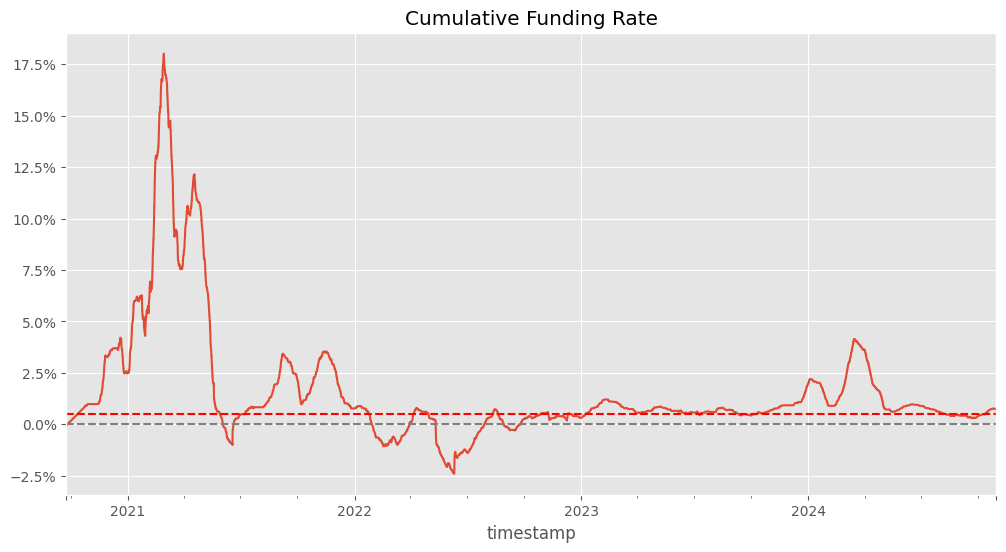

In [57]:
# 绘制折线图查看累计融资利率
fig, ax = plt.subplots(figsize=(12, 6))
df_joined["cumulative_funding"].plot(ax=ax)
ax.plot(df_joined.index, df_joined["cumulative_funding"])
ax.set_title("Cumulative Funding Rate")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=1))

# 添加水平阈值
threshold = 0.005
ax.axhline(threshold, color="r", linestyle="--", label="Threshold")
ax.axhline(0, color="grey", linestyle="--", label="Zero")

## 交易策略

假设交易成本：
- 现货进场佣金：0.1%
- 现货平仓佣金：0.1%
- 合约进场佣金：0.05%
- 合约平仓佣金：0.05%
- 进场价差：0.1%
- 平仓价差：0.1%

从开仓到平仓，每次交易的成本约为0.5%。

进场条件：
- 30天累计融资利率超过0.5%，建立头寸，做多现货，做空合约

平仓条件：
- 30天累计融资利率低于0%，平仓头寸

调仓：
- 当合约头寸的亏损超过70%，全部平仓，根据新的融资利率判断是否重新建仓

In [47]:
class FundingRateArbitrage:
    """回溯检验融资利率套利策略

    策略逻辑：
    - 当累计融资利率超过阈值时开仓，买入现货，做空永续合约
    - 当累计融资利率低于阈值时平仓
    - 当合约空头亏损超过阈值时平仓
    """

    def __init__(
        self,
        cumulative_funding_days: int,
        entry_threshold: float,
        exit_threshold: float,
        max_short_position_loss: float,
        capital: float = 10000,
        leverage: float = 1,
        spot_fee: float = 0.001,
        perp_fee: float = 0.0005,
    ):
        # 策略参数
        self.cumulative_funding_days = cumulative_funding_days
        self.entry_threshold = entry_threshold
        self.exit_threshold = exit_threshold
        self.max_short_position_loss = max_short_position_loss

        # 回溯检验设置
        self.capital = capital
        self.leverage = leverage
        self.spot_fee = spot_fee
        self.perp_fee = perp_fee

        # 跟踪策略变量
        self.positions: np.ndarray = None
        self.capitals: np.ndarray = None

        self.spot_entry_price: float = 0
        self.spot_exit_price: float = 0
        self.spot_amount: float = 0
        self.spot_entry_fee: float = 0
        self.spot_exit_fee: float = 0

        self.perp_entry_price: float = 0
        self.perp_exit_price: float = 0
        self.perp_amount: float = 0
        self.perp_entry_fee: float = 0
        self.perp_exit_fee: float = 0

    def initialize(self, data: pd.DataFrame) -> None:
        """
        输入数据必须包含以下字段：spot_open, spot_close, perp_open, perp_close, funding_rate
        """
        self.data = data.copy()
        self.data["cumulative_funding"] = (
            self.data["funding_rate"]
            .rolling(dt.timedelta(days=self.cumulative_funding_days))
            .sum()
        )
        self.positions = np.zeros(len(self.data))
        self.capitals = np.zeros(len(self.data))

    def open_position(self, idx: int, row: pd.Series) -> None:
        print("=== Open Position ===")

        available_capital = self.capitals[idx]

        # 买入现货，使用95%的资金开仓，剩余5%用于支付手续费
        self.spot_entry_price = row["open_spot"]
        self.spot_amount = available_capital / 2 * 0.95 / self.spot_entry_price
        self.spot_entry_fee = -(
            self.spot_entry_price * self.spot_amount * self.spot_fee
        )
        print(
            f"Buy spot: price={self.spot_entry_price:.2f}, amount={self.spot_amount:.2f}, fee={self.spot_entry_fee:.2f}"
        )

        # 做空永续合约
        self.perp_entry_price = row["open_perp"]
        self.perp_amount = available_capital / 2 * 0.95 / self.perp_entry_price
        self.perp_entry_fee = -(
            self.perp_entry_price * self.perp_amount * self.perp_fee
        )
        print(
            f"Sell perp: price={self.perp_entry_price:.2f}, amount={self.perp_amount:.2f}, fee={self.perp_entry_fee:.2f}"
        )

        # 更新头寸和盈亏
        total_fee = self.spot_entry_fee + self.perp_entry_fee
        self.positions[idx] = 1
        self.capitals[idx] += total_fee
        print(f"Position: 0 -> 1")
        print(f"Total fee: {total_fee:.2f}")
        print(f"Capital: {available_capital:.2f} -> {self.capitals[idx]:.2f}")

        print("=====================")

    def close_position(self, idx: int, row: pd.Series) -> None:
        print("=== Close Position ===")

        # 卖出现货
        self.spot_exit_price = row["open_spot"]
        self.spot_exit_fee = -(self.spot_exit_price * self.spot_amount * self.spot_fee)
        spot_pnl = (self.spot_exit_price - self.spot_entry_price) * self.spot_amount
        print(
            f"Sell spot: price={self.spot_exit_price:.2f}, amount={self.spot_amount:.2f}, fee={self.spot_exit_fee:.2f}, pnl={spot_pnl:.2f}"
        )

        # 买入永续合约
        self.perp_exit_price = row["open_perp"]
        self.perp_exit_fee = -(self.perp_exit_price * self.perp_amount * self.perp_fee)
        perp_pnl = (self.perp_entry_price - self.perp_exit_price) * self.perp_amount
        print(
            f"Buy perp: price={self.perp_exit_price:.2f}, amount={self.perp_amount:.2f}, fee={self.perp_exit_fee:.2f}, pnl={perp_pnl:.2f}"
        )

        # 更新头寸和盈亏
        prev_capital = self.capitals[idx]
        total_fee = self.spot_exit_fee + self.perp_exit_fee
        trading_pnl = spot_pnl + perp_pnl
        self.positions[idx] = 0
        self.capitals[idx] += trading_pnl + total_fee
        print(f"Position: 1 -> 0")
        print(f"Trading pnl: {trading_pnl:.2f}")
        print(f"Total fee: {total_fee:.2f}")
        print(f"Capital: {prev_capital:.2f} -> {self.capitals[idx]:.2f}")

        # 平仓后重置变量
        self.reset_position_variables()

        print("=====================")

    def reset_position_variables(self) -> None:
        self.spot_entry_price = 0
        self.spot_exit_price = 0
        self.spot_amount = 0
        self.spot_entry_fee = 0
        self.spot_exit_fee = 0
        self.perp_entry_price = 0
        self.perp_exit_price = 0
        self.perp_amount = 0
        self.perp_entry_fee = 0
        self.perp_exit_fee = 0

    def run_backtest(self, data: pd.DataFrame) -> None:
        self.initialize(data)

        for idx, (ts, row) in enumerate(self.data.iterrows()):
            if idx == 0:
                self.capitals[idx] = self.capital
                continue

            # 获取前一根K线收盘后的数据
            prev_position = self.positions[idx - 1]
            prev_capital = self.capitals[idx - 1]
            prev_funding = self.data["funding_rate"].iloc[idx - 1]
            prev_cumulative_funding = self.data["cumulative_funding"].iloc[idx - 1]

            # 更新当前时间点的头寸和账户资本
            self.positions[idx] = prev_position
            self.capitals[idx] = prev_capital

            print(
                f"{ts}: PrevPos={prev_position:.0f}, PrevCapital={prev_capital:.2f}, PrevFunding={prev_funding:.3%}, PrevCumFunding={prev_cumulative_funding:.3%}"
            )

            # 计算融资利率收入
            if prev_position > 0 and abs(prev_funding) > 0:
                funding_income = self.perp_entry_price * self.perp_amount * prev_funding
                self.capitals[idx] += funding_income
                print(
                    f"FundingIncome={funding_income:.3f}, Capital={self.capitals[idx]:.2f}"
                )

            # 开仓
            if prev_position == 0 and prev_cumulative_funding > self.entry_threshold:
                self.open_position(idx, row)

            # 平仓：累计融资利率低于阈值
            if prev_position > 0 and prev_cumulative_funding < self.exit_threshold:
                self.close_position(idx, row)

            # 平仓：合约空头亏损超过阈值
            if prev_position > 0 and self.positions[idx] != 0:
                perp_pnl_pct = (
                    self.perp_entry_price - row["open_perp"]
                ) / self.perp_entry_price
                if perp_pnl_pct <= -self.max_short_position_loss:
                    print(f"Perp pnl pct: {perp_pnl_pct:.1%}")
                    self.close_position(idx, row)

    def plot_equity_curve(self) -> None:
        capitals = pd.Series(self.capitals, index=self.data.index)
        capitals.plot(figsize=(12, 6), title="Equity Curve")

    def calculate_performance(self) -> ffn.core.PerformanceStats:
        capitals = pd.Series(self.capitals, index=self.data.index)
        return capitals.calc_stats()

In [58]:
data = df_joined.drop(columns=["cumulative_funding"]).copy()
data

,open_spot,close_spot,open_perp,close_perp,funding_rate
timestamp,,,,,
2020-09-24 04:00:00,0.03493,0.03577,0.034630,0.035407,0.00000
2020-09-24 08:00:00,0.03577,0.03626,0.035478,0.036342,-0.00039
2020-09-24 12:00:00,0.03640,0.03952,0.036349,0.039540,0.00000
2020-09-24 16:00:00,0.03966,0.03962,0.039540,0.039790,0.00010
2020-09-24 20:00:00,0.03962,0.03968,0.039701,0.039761,0.00000
...,...,...,...,...,...
2024-10-29 08:00:00,0.70620,0.71410,0.706000,0.714000,0.00010
2024-10-29 12:00:00,0.71410,0.71780,0.713900,0.717900,0.00000
2024-10-29 16:00:00,0.71790,0.70790,0.717900,0.708200,0.00010


In [59]:
arbitrage_strategy = FundingRateArbitrage(
    cumulative_funding_days=30,
    entry_threshold=0.005,
    exit_threshold=0,
    max_short_position_loss=0.7,
    capital=10000,
    leverage=1,
    spot_fee=0.001,
    perp_fee=0.0005,
)

arbitrage_strategy.run_backtest(data)

2020-09-24 08:00:00: PrevPos=0, PrevCapital=10000.00, PrevFunding=0.000%, PrevCumFunding=0.000%
2020-09-24 12:00:00: PrevPos=0, PrevCapital=10000.00, PrevFunding=-0.039%, PrevCumFunding=-0.039%
2020-09-24 16:00:00: PrevPos=0, PrevCapital=10000.00, PrevFunding=0.000%, PrevCumFunding=-0.039%
2020-09-24 20:00:00: PrevPos=0, PrevCapital=10000.00, PrevFunding=0.010%, PrevCumFunding=-0.029%
2020-09-25 00:00:00: PrevPos=0, PrevCapital=10000.00, PrevFunding=0.000%, PrevCumFunding=-0.029%
2020-09-25 04:00:00: PrevPos=0, PrevCapital=10000.00, PrevFunding=0.010%, PrevCumFunding=-0.019%
2020-09-25 08:00:00: PrevPos=0, PrevCapital=10000.00, PrevFunding=0.000%, PrevCumFunding=-0.019%
2020-09-25 12:00:00: PrevPos=0, PrevCapital=10000.00, PrevFunding=0.010%, PrevCumFunding=-0.009%
2020-09-25 16:00:00: PrevPos=0, PrevCapital=10000.00, PrevFunding=0.000%, PrevCumFunding=-0.009%
2020-09-25 20:00:00: PrevPos=0, PrevCapital=10000.00, PrevFunding=0.010%, PrevCumFunding=0.001%
2020-09-26 00:00:00: PrevPos=0,

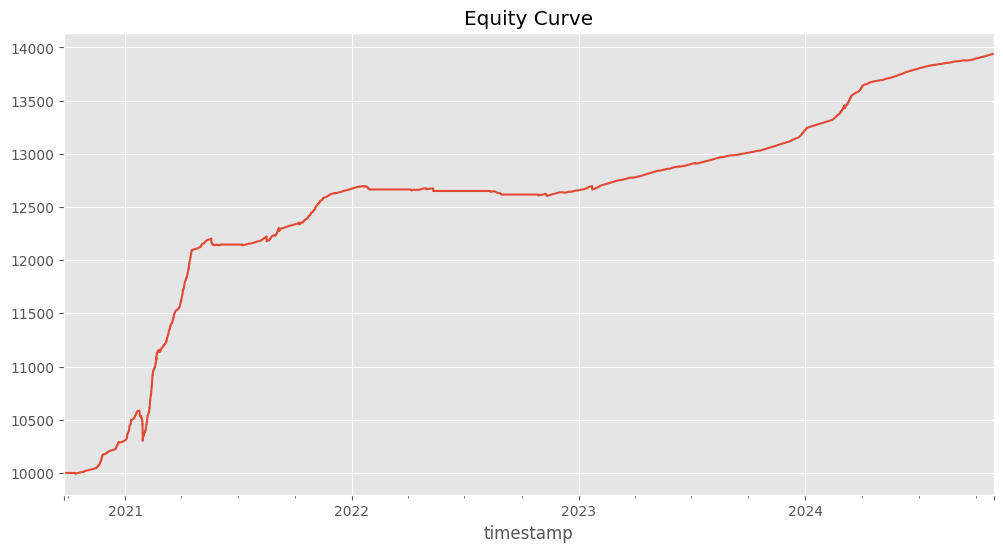

In [60]:
arbitrage_strategy.plot_equity_curve()

In [61]:
stats = arbitrage_strategy.calculate_performance()
stats.display()

Stats for None from 2020-09-24 04:00:00 - 2024-10-30 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
39.41%              4.81  8.44%   -2.37%

Annualized Returns:
mtd    3m     6m     ytd    1y     3y     5y     10y    incep.
-----  -----  -----  -----  -----  -----  -----  -----  --------
0.33%  0.72%  1.82%  5.41%  6.83%  3.81%  8.44%  -      8.44%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  4.81     1.79       0.81
mean    5.60%    8.26%      8.19%
vol     1.16%    4.63%      10.15%
skew    -0.40    3.89       1.65
kurt    70.63    17.16      3.08
best    0.70%    7.73%      22.98%
worst   -1.18%   -0.27%     -0.13%

Drawdowns:
max     avg       # days
------  ------  --------
-2.37%  -0.15%      16.7

Misc:
---------------  ------
avg. up month    0.86%
avg. down month  -0.06%
up year %        75.00%
12m up %         92.31%
-------